In [1]:
import pandas as pd 
import numpy as np 
import re
import openpyxl
import datetime
import pickle
from functools import reduce
import os
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

## Read CSV

In [2]:
# client level
df_clients = pd.read_csv('clients.csv')
df_clients.columns = [i.lower() for i in df_clients.columns.values]

# customer level
df_customers = pd.read_csv('customers.csv')
df_customers.columns = [i.lower() for i in df_customers.columns.values]

# attempt level
df_messages = pd.read_csv('messages.csv')
df_messages.columns = [i.lower() for i in df_messages.columns.values]

## Data manipulation, EDA and imputation

In [3]:
#-----------------------------------------------------------------------
# merge client details to customer level data
# impute age and country by cohort, created by client details
#-----------------------------------------------------------------------

# check duplications in df_clients
df_clients.fillna('na').groupby(by='id',as_index=False)['name'].count().sort_values(by='name',ascending=0)
# no duplication, dedup anyway
print(f"clients rows bf dedup:{df_clients.shape[0]}")
df_clients.drop_duplicates(subset='id',keep='first',inplace=True)
print(f"clients rows aft dedup:{df_clients.shape[0]}")

# merge
print(f"customers rows bf merged with clients:{df_customers.shape[0]}")
rename_dict = {'id':'client_id','country':'client_country'}
dfs = [df_customers, df_clients.rename(columns=rename_dict)]
df_clients_customers = reduce(lambda left,right: pd.merge(left,right,on='client_id',how='left'), dfs)
print(f"customers rows aft merged with clients:{df_clients_customers.shape[0]}")

# impute customer's country with client's country

df_clients_customers['country'] = np.where(df_clients_customers['country'].isnull(),
                                           df_clients_customers['client_country'],
                                           df_clients_customers['country'])
# check missing country
# UK    4490
# CA    2995
# NZ    2515
# df_clients_customers['country'].value_counts(dropna=False)
# no missing country

clients rows bf dedup:8
clients rows aft dedup:8
customers rows bf merged with clients:10000
customers rows aft merged with clients:10000


d.50up     3775
b.25-39    3264
a.<25      1969
c.40-49     992
Name: age_grp, dtype: int64
F    5287
M    4713
Name: gender, dtype: int64


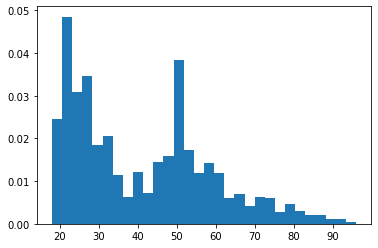

In [4]:
#-----------------------------------------------------------------------
# see age distribution
#
# range(0,110,10)
# [18., 21., 24., 26., 30., 38., 47., 51., 56., 65., 96.]
#
# quarters [0,25,50,75,100]
# [18. 25. 38. 52. 96.]
#
# extremes [0,1,5,10,90,95,99,100]
# [18., 19., 20., 21., 65., 74., 87., 96.]
#-----------------------------------------------------------------------

# np.percentile(df_clients_customers.dropna()['age'],range(0,110,10))
# np.percentile(df_clients_customers.dropna()['age'],[0,1,5,10,90,95,99,100])
# np.percentile(df_clients_customers.dropna()['age'],[0,25,50,75,100])

# visualize
plt.hist(df_clients_customers.dropna()['age'], density=True, bins=30)

# from the visualize divide by quarter make sense
# as age is divided into jobbers (BNPL target), early-mid career, late career and pensioners
# or generations: gen Z, millenials, gen X, boomers

def age_grp(age):
    if pd.isnull(age):
        age_grp = None
    elif age < 25:
        age_grp = 'a.<25'
    elif age < 40:
        age_grp = 'b.25-39'
    elif age < 50:
        age_grp = 'c.40-49'
    else:
        age_grp = 'd.50up'
    return age_grp

df_clients_customers['age_grp'] = df_clients_customers['age'].apply(age_grp)

# impute customer's age_grp by cohort
# cohort is formed by country and product_type
# create dictionary containing mode age_grp of each cohort key

age_impute_dict = df_clients_customers.groupby(by=['country','product_type'])['age_grp'].apply(lambda x: x.mode().iloc[0]).to_dict()
df_clients_customers['age_grp'] = df_clients_customers.apply(lambda row: age_impute_dict[(row['country'],row['product_type'])] if pd.isnull(row['age']) else row['age_grp'],axis=1)
print(df_clients_customers['age_grp'].value_counts(dropna=False))

# impute customer's gender by cohort
# cohort is formed by country, product_type and age_grp
# create dictionary containing mode gender of each cohort key

gender_impute_dict = df_clients_customers.groupby(by=['country','product_type','age_grp'])['gender'].apply(lambda x: x.mode().iloc[0]).to_dict()
df_clients_customers['gender'] = df_clients_customers.apply(lambda row: gender_impute_dict[(row['country'],row['product_type'],row['age_grp'])] if pd.isnull(row['gender']) else row['gender'],axis=1)
print(df_clients_customers['gender'].value_counts(dropna=False))

### save age_impute_dict and gender_impute_dict
with open('./trg/age_impute_dict.pkl', 'wb') as f:
    pickle.dump(age_impute_dict, f)
with open('./trg/gender_impute_dict.pkl', 'wb') as f:
    pickle.dump(gender_impute_dict, f)

## save df_clients_customers

df_clients_customers.to_pickle("./trg/customer_details.pkl")


0         2021-01-04 10:03:16.376000+00:00
1         2021-01-04 10:42:47.027000+00:00
2         2021-01-04 11:18:23.996000+00:00
3         2021-01-04 12:53:56.733000+00:00
4         2021-01-04 12:54:02.700000+00:00
                        ...               
145936    2021-10-01 19:55:16.059000+00:00
145937    2021-10-01 19:56:00.363000+00:00
145938    2021-10-01 19:57:24.141000+00:00
145939    2021-10-01 19:58:07.041000+00:00
145940    2021-10-01 19:58:46.086000+00:00
Name: sent_at, Length: 145941, dtype: object

In [113]:
#-----------------------------------------------------------------------
# analysis needsto be done at attempt level
# map client and customer details to attempt level data
#-----------------------------------------------------------------------

# check missing 'sent_at' and 'clicked' in df_messages
df_messages.loc[:, df_messages.isnull().any()].columns
# no missing

# merge
print(f"messages rows bf merged with clients:{df_messages.shape[0]}")
rename_dict = {'id':'customer_id'}
# 'converted','age' and 'client_country' are not needed
dfs = [df_messages.drop(columns='converted',axis=1), 
       df_clients_customers.rename(columns=rename_dict).drop(columns=['age','client_country'],axis=1)]
df = reduce(lambda left,right: pd.merge(left,right,on='customer_id',how='left'), dfs)
print(f"messages rows aft merged with clients_customers:{df_messages.shape[0]}")

# create ordinal feature - time of week
# first digit represent day of week, starting from Monday (1)
# second and third digit represent hour of day

df['sent_at'] = df['sent_at'].apply(lambda x: datetime.datetime.strptime(x[:19],'%Y-%m-%d %H:%M:%S'))
df['time_of_week'] = df['sent_at'].apply(lambda x: (int(x.isoweekday())*100)+int(x.strftime('%H')))
df['time_of_week'].value_counts(dropna=False)

messages rows bf merged with clients:145941
messages rows aft merged with clients_customers:145941


209    7803
510    7685
309    7679
310    7652
409    7573
509    7533
410    7527
210    7520
511    5481
311    5477
211    5442
411    5438
208    3254
408    3170
308    3150
508    3111
111    1620
114    1443
116    1422
213    1412
514    1412
413    1408
113    1401
216    1399
314    1399
412    1391
416    1388
512    1386
212    1372
214    1369
515    1368
313    1360
414    1360
215    1349
115    1344
516    1339
312    1332
513    1324
415    1323
316    1315
315    1307
112    1291
110    1280
109    1190
117    1071
517    1062
417    1049
217    1046
317    1008
318     679
519     640
518     636
119     634
218     633
319     631
108     629
418     623
118     619
419     613
219     569
Name: time_of_week, dtype: int64

# Main Idea
### 1) build a binary classification model to predict 'clicked', 'time of week' being one of the feature
### 2) Once the model is ready, since everything else is constant, the only degree of freedom is time to message
### 3) We then put in all possible hour of the week and pick only hour which product top probability of cliked

Index(['id', 'clicked', 'gender', 'country', 'product_type', 'age_grp',
       'time_of_week'],
      dtype='object')

## build pipeline

In [135]:
cols_to_drop = ['client_id','customer_id','sent_at','created_at','name']
df_abt = df.drop(columns=cols_to_drop,axis=1)

# manipulate content in columns to lower case
lower_case_cols = ['gender','country','product_type']
for col in lower_case_cols:
    df_abt[col] = df_abt[col].apply(lambda x: x.lower()) 

target = 'clicked'

# ordinal
ordinal_features = ['age_grp','time_of_week']

#levels for ordinals
cat_age_lvl = [sorted(df_abt['age_grp'].unique())]
cat_tow_lvl = [sorted([(i*100)+j for j in range(0,24) for i in range(1,8)])]

# categorical
cat_gender = [df_abt['gender'].unique()]
cat_country= [df_abt['country'].unique()]
cat_product_type = [df_abt['product_type'].unique()]

# Prepare scaler, preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('age_grp',OrdinalEncoder(categories=cat_age_lvl), ['age_grp']),
        ('time_of_week',OrdinalEncoder(categories=cat_tow_lvl), ['time_of_week']),
        ('gender', OneHotEncoder(categories=cat_gender,handle_unknown='ignore'), ['gender']),
        ('country', OneHotEncoder(categories=cat_country,handle_unknown='ignore'), ['country']),
        ('product_type', OneHotEncoder(categories=cat_product_type,handle_unknown='ignore'), ['product_type'])
    ]
)

# Prepare transformed column names

transformers = preprocessor.transformers

def get_features_names(transformer):
    transformed_cols = []
    steps = range(len(transformer))
    for step in steps:
        if type(transformers[step][1]) == type(OrdinalEncoder()):
            ordinal_cols = transformers[step][-1]
            transformed_cols = transformed_cols + [i for i in ordinal_cols]
        else:
            new_cols = [i+'_'+j for j in transformers[step][1].categories[0] for i in transformers[step][-1]]
            transformed_cols = transformed_cols + [i for i in new_cols]
    return transformed_cols

transformed_cols = get_features_names(transformers)


## Train-test split

X = df_abt.drop(columns=target,axis=1)
Y = df_abt[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    random_state=9000, 
                                                    test_size=0.2,
                                                    stratify=Y)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('clf',GradientBoostingClassifier())]) #dummy

k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Hyperparameters 

param_grid = [{'clf':[GradientBoostingClassifier()],
            'clf__n_estimators': [100],
            'clf__max_depth': [3,4],
            'clf__min_samples_leaf': [2,3],
            'clf__learning_rate': [0.1,0.05,0.03,0.01]
            },
            {'clf':[RandomForestClassifier()],
            'clf__n_estimators': [500],
            'clf__max_depth': [4,5,6],
            'clf__max_features':['sqrt'],
            'clf__min_samples_leaf': [2,3]}]

best_model = GridSearchCV(pipe, param_grid = param_grid, scoring='accuracy',
                          cv = k_fold, n_jobs = -1, verbose = 1)

# fit pipeline
best_model.fit(X_train, y_train)

# score
y_pred = best_model.predict(X_test)


Fitting 3 folds for each of 22 candidates, totalling 66 fits


In [136]:
def get_kpis(pipeline,y_pred):

    # Calculat Accuracy, Precision, Recall, F1 Score

    # metrics = precision_recall_fscore_support(y_test, pipeline.predict(X_test))
    accuracy =accuracy_score(y_test, y_pred)
    precision =precision_score(y_test, y_pred, average='weighted',zero_division=0)
    recall =recall_score(y_test, y_pred, average='weighted',zero_division=0)
    f1 =f1_score(y_test, y_pred, average='weighted',zero_division=0)

    print(f"classifier: {pipeline.best_estimator_.named_steps['clf']}")
    print("Model Accuracy: {:.3f}".format(accuracy))
    print("Precision of postive cases: {:.2f}".format(precision))
    print("Recall of postive cases: {:.2f}".format(recall))
    print("F1 Score of postive cases: {:.2f}".format(f1))

get_kpis(best_model,y_pred)

classifier: GradientBoostingClassifier(min_samples_leaf=2)
Model Accuracy: 0.936
Precision of postive cases: 0.88
Recall of postive cases: 0.94
F1 Score of postive cases: 0.90


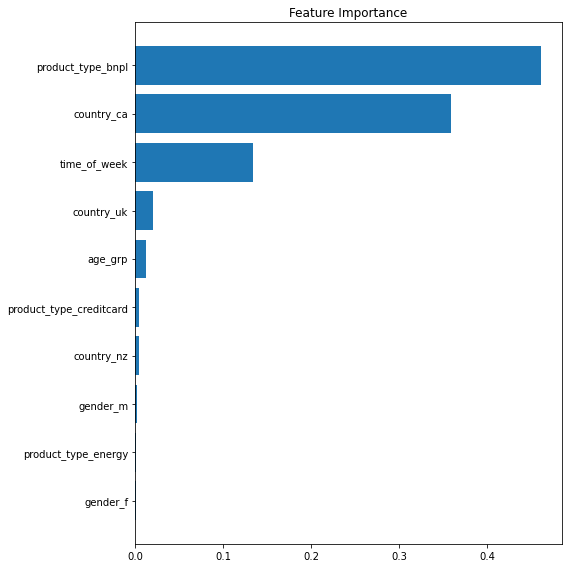

In [138]:
def get_feature_importance(clf,y_pred):
    '''Get Feature importance data using feature_importances_ attribute'''

    feature_importance = clf.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(8, 8))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(transformed_cols)[sorted_idx])
    plt.title('Feature Importance')
    fig.tight_layout()

get_feature_importance(best_model.best_estimator_.named_steps['clf'],y_pred)

## Save pipeline for preprocessor and model

In [140]:
with open('./trg/model_pipeline.pkl', 'wb') as f:
    pickle.dump(best_model.best_estimator_, f)